# Dataset #
**Size:**
* 70,000 instances
* 12 features

**Features:**

* Age | Objective Feature | age | int (days)
* Height | Objective Feature | height | int (cm) |
* Weight | Objective Feature | weight | float (kg) |
* Gender | Objective Feature | gender | categorical code |
* Systolic blood pressure | Examination Feature | ap_hi | int |
* Diastolic blood pressure | Examination Feature | ap_lo | int |
* Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
* Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
* Smoking | Subjective Feature | smoke | binary |
* Alcohol intake | Subjective Feature | alco | binary |
* Physical activity | Subjective Feature | active | binary |
* Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [201]:
#importing packages
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score,roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [137]:
df = pd.read_csv('cardio_train.csv',delimiter=';')
df.shape

(70000, 13)

In [138]:
# data exploration
print('size: ',df.shape)
print('info:',df.info())
print('null values:',df.isnull().values.any())

size:  (70000, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
id             70000 non-null int64
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
info: None
null values: False


**Removing Outliers**

In [139]:
# dropping unnecessary columns
df.drop('id',axis=1,inplace=True)

In [140]:
df[df['ap_lo'] > df['ap_hi']].shape[0]

1234

In [141]:
df[(df['height'] < df['height'].quantile(0.025))].shape

(1537, 12)

In [142]:
df[(df['height'] > df['height'].quantile(0.975))].shape

(1439, 12)

In [143]:
df[(df['ap_hi']>df['ap_hi'].quantile(0.975))].shape

(1114, 12)

* Remove outliers in height, weight that fall below 2.5% and above 97.5%
* Remove outliers, where diastolic pressure is higher than systolic, which is incorrect

In [144]:
# height, weight
df.drop(df[(df['height'] > df['height'].quantile(0.975)) 
           | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) 
           | (df['weight'] < df['weight'].quantile(0.025))].index, inplace=True)

In [145]:
# blood pressure
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) 
           | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) 
           | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)

In [146]:
df.shape

(60142, 12)

In [148]:
# new feature BMI index
df['bmi'] = df['weight']/((df['height']/100)**2)

In [209]:
df.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,years
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,50
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,55
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,52


In [132]:
# corr = df.corr()
# cmap = sns.diverging_palette(220,10,as_cmap=True)
# mask = np.zeros_like(corr,dtype=np.bool)
# mask[np.triu_indices_from(mask)]=True

# f, ax = plt.subplots(figsize=(11,9))
# sns.heatmap(corr,mask=mask,cmap=cmap,vmax=0.3,center=0,annot=True, 
#             square=True,linewidth=0.5,cbar_kws={'shrink':0.5});

# # plt.savefig('correlation_heatmap.png')

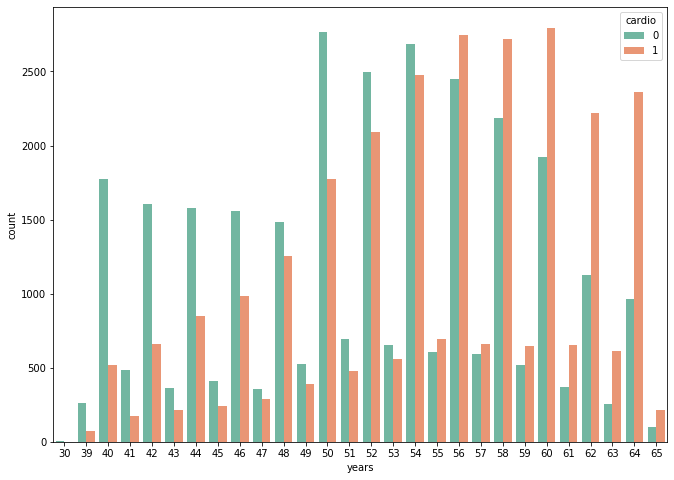

In [211]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
df['years'] = (df['age'] / 365).round().astype('int')
sns.countplot(x='years', hue='cardio', data = df, palette="Set2");
# plt.savefig('age_cdv.png')
plt.show()

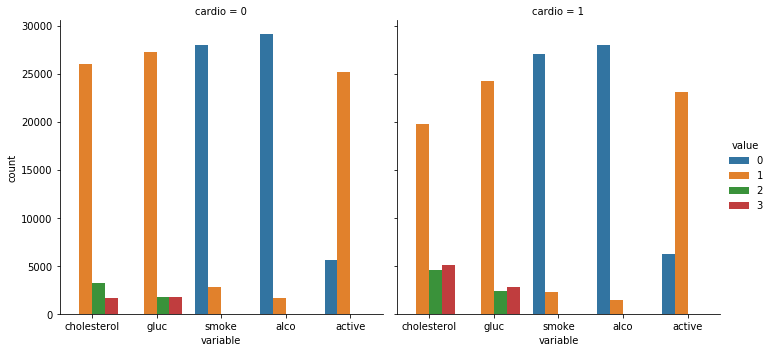

In [212]:
df_long = pd.melt(df, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value", col="cardio",
                data=df_long, kind="count");
# plt.savefig('binary_features.png')

In [213]:
y = df['cardio']
X = df.drop('cardio',axis=1)

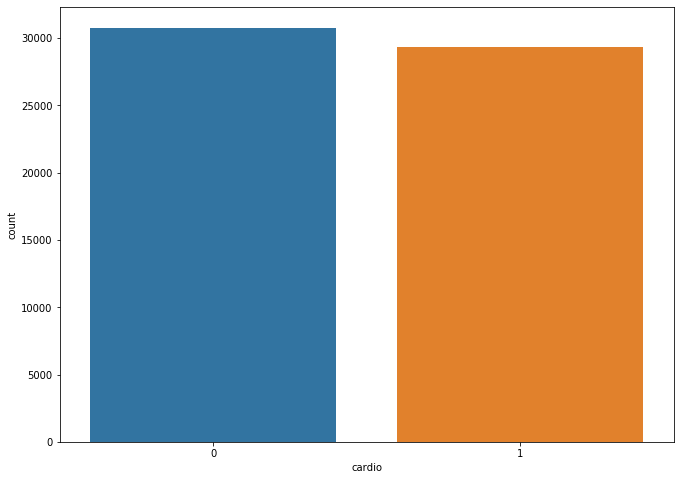

In [114]:
# we have pretty balanced dataset
sns.countplot(y)
# plt.savefig('balanced.png')

In [214]:
# splitting the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [216]:
X_train.drop('age',axis=1,inplace=True)

In [217]:
# feature scaling
# scaled only continuous values
ss = StandardScaler()
X_train[['years','height','weight','ap_hi','ap_lo','bmi']] = ss.fit_transform(X_train[['years','height','weight','ap_hi','ap_lo','bmi']])
X_test[['years','height','weight','ap_hi','ap_lo','bmi']] = ss.fit_transform(X_test[['years','height','weight','ap_hi','ap_lo','bmi']])

In [218]:
X_train.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,years
24746,2,1.529052,0.568454,1.752463,-0.130269,1,1,0,0,1,-0.237365,0.098441
19479,1,-0.668709,-0.295274,1.752463,1.085346,1,1,0,0,1,0.040702,-0.494088
15537,1,-1.401297,-0.986256,1.026916,-0.130269,1,1,0,0,1,-0.309312,-0.197824
39116,2,2.261639,0.050217,1.026916,0.963784,1,1,0,0,0,-0.984832,-1.975409
64308,1,0.063878,1.864047,0.301368,1.085346,3,3,0,0,0,1.759847,0.690969


# Fitting to models and comparing results
___
* Logistic Regression
* KNeighbors
* Naive Bayes
* Decision Tree
* SVM (linear)
* Random Forest
* Xtra Trees Classifier
* Ada Boost

In [219]:
# logistic regression

logistic = LogisticRegression(random_state=12345)
hyperparameters = {'penalty':('l1','l2'),'C':[1,3]}
clf = GridSearchCV(logistic, hyperparameters, cv=3, verbose=0)
best_model = clf.fit(X_train, y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

y_pred = best_model.predict(X_test)
y_hat_proba = best_model.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, y_hat_proba)
roc_auc = auc(fpr, tpr)
# log reg curve
# log_curve = sns.regplot(x=y_hat_proba, y=y_test, data=None, logistic=True)
# plt.title('Probability Curve')

# ROC Curve
# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

cm = confusion_matrix(y_test,y_pred)

print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print('Recall', recall_score(y_pred,y_test))
print(cm)
print('Recall', recall_score(y_pred,y_test))
print('Precision',precision_score(y_pred,y_test))

Best Penalty: l1
Best C: 1


ValueError: X has 13 features per sample; expecting 12

In [ ]:
# # decision tree grid search
# dt = DecisionTreeClassifier(random_state=12345)
# hyperparameters = {'criterion':('entropy','gini'),'min_samples_split':range(2,10,2),'max_depth':range(1,10,2)}
# clf = GridSearchCV(dt, hyperparameters, cv=3, verbose=0)
# best_model = clf.fit(X_train, y_train)

# print('Best Citerion:', best_model.best_estimator_.get_params()['criterion'])
# print('Best Num Split:', best_model.best_estimator_.get_params()['min_samples_split'])
# print('Best Depth:', best_model.best_estimator_.get_params()['max_depth'])

# y_pred = best_model.predict(X_test)
# y_hat_proba = best_model.predict_proba(X_test)[:,1]

# scores = cross_val_score(best_model,X_test,y_pred, cv=5)
# cm = confusion_matrix(y_test,y_pred)


# print('Accuracy', accuracy_score(y_test,y_pred))
# print('AUC_ROC',roc_auc_score(y_pred,y_test))
# print(cm)
# print('Recall', recall_score(y_pred,y_test))
# print('Precision',precision_score(y_pred,y_test))

In [ ]:
# we tuned the parameters for the model, now we can manully set them
dt = DecisionTreeClassifier(criterion='entropy',min_samples_split=2,max_depth=5,random_state=12345)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
y_hat_proba = dt.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, y_hat_proba)
roc_auc = auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()
scores = cross_val_score(dt,X_test,y_pred, cv=5)
cm = confusion_matrix(y_test,y_pred)

print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(cm)
print('Recall', recall_score(y_pred,y_test))
print('Precision',precision_score(y_pred,y_test))


In [ ]:
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = StringIO()
# export_graphviz(dt, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names=X.columns)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

In [ ]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)
y_hat_proba = nb.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, y_hat_proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

cm = confusion_matrix(y_test,y_pred)
print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(cm)
print('Recall', recall_score(y_pred,y_test))
print('Precision',precision_score(y_pred,y_test))

In [ ]:
# SVM 
svm = LinearSVC(dual=False,random_state=12345)
hyperparameters = {'penalty':('l1','l2'),
                   'C':[1,3]}

clf = GridSearchCV(svm, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

y_pred = best_model.predict(X_test)
# y_hat_proba = best_model.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test,y_pred)
scores = cross_val_score(best_model,X_test,y_pred, cv= 5)

print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(scores.mean())
print(cm)
print('Recall', recall_score(y_pred,y_test))
print('Precision',precision_score(y_pred,y_test))

In [ ]:
# SVM 
svm = LinearSVC(penalty='l2',C=1,random_state=12345)
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(cm)
print('Recall', recall_score(y_pred,y_test))
print('Precision',precision_score(y_pred,y_test))

In [ ]:
# # SVM - SGDClassifier 
# svm = SGDClassifier(eta0=1,random_state=12345)
# hyperparameters = {'loss':('log','perceptron'),
#                    'penalty':('l1','l2','elasticnet'),
#                    'learning_rate':('constant','optimal','invscaling','adaptive')}
# clf = GridSearchCV(svm, hyperparameters, cv=5, verbose=0)
# best_model = clf.fit(X_train, y_train)

# print('Best Loss:', best_model.best_estimator_.get_params()['loss'])
# print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])

# y_pred = best_model.predict(X_test)
# # y_hat_proba = best_model.predict_proba(X_test)[:,1]

# cm = confusion_matrix(y_test,y_pred)
# scores = cross_val_score(best_model,X_test,y_pred, cv= 5)

# print('Accuracy', accuracy_score(y_test,y_pred))
# print('AUC_ROC',roc_auc_score(y_pred,y_test))
# print(scores.mean())
# print(cm)
# print('Recall', recall_score(y_pred,y_test))
# print('Precision',precision_score(y_pred,y_test))

In [ ]:
# knn = KNeighborsClassifier(metric='minkowski',weights='uniform')
# hyperparameters = {'n_neighbors':range(3,10,1), 'p':[1,2]}
# clf = GridSearchCV(knn, hyperparameters, cv=5, verbose=0,n_jobs=-1)
# best_model = clf.fit(X_train, y_train)

# print('Best K_value:', best_model.best_estimator_.get_params()['n_neighbors'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])

# y_pred = best_model.predict(X_test)
# y_hat_proba = best_model.predict_proba(X_test)[:,1]

# scores = cross_val_score(best_model,X_test,y_pred, cv= 5)
# cm = confusion_matrix(y_test,y_pred)

# print('Accuracy', accuracy_score(y_test,y_pred))
# print('AUC_ROC',roc_auc_score(y_pred,y_test))
# print(cm)
# print(scores.mean())
# print('Recall', recall_score(y_pred,y_test))
# print('Precision',precision_score(y_pred,y_test))

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=9,metric='minkowski',weights='uniform',p=1)
knn.fit(X_train, y_train)
y_pred =  knn.predict(X_test)

y_hat_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_hat_proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

cm = confusion_matrix(y_test,y_pred)
print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(cm)
print('Recall', recall_score(y_pred,y_test))
print('Precision',precision_score(y_pred,y_test))

In [ ]:
# # random forest
# rf = RandomForestClassifier()
# hyperparameters = {'n_estimators':range(10,20,2), 
#                    'criterion':('entropy','gini'),
#                    'max_depth':range(1,10,2),
#                    'min_samples_split':range(2,10,1)}

# clf = GridSearchCV(rf, hyperparameters, cv=5, verbose=0,n_jobs=-1)
# best_model = clf.fit(X_train, y_train)

# print('Best Citerion:', best_model.best_estimator_.get_params()['criterion'])
# print('Best n_estimator:', best_model.best_estimator_.get_params()['n_estimators'])
# print('Best min_sample_splits:', best_model.best_estimator_.get_params()['min_samples_split'])
# print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

# y_pred = best_model.predict(X_test)
# y_hat_proba = best_model.predict_proba(X_test)[:,1]

# scores = cross_val_score(best_model,X_test,y_pred, cv= 5)
# cm = confusion_matrix(y_test,y_pred)

# print('Accuracy', accuracy_score(y_test,y_pred))
# print('AUC_ROC',roc_auc_score(y_pred,y_test))
# print(cm)
# print('Recall', recall_score(y_pred,y_test))
# print('Precision',precision_score(y_pred,y_test))

In [ ]:
rf = RandomForestClassifier(n_estimators=18,criterion='gini',min_samples_split=2,
                            max_depth=9,random_state=12345)
rf.fit(X_train,y_train)
y_pred =  rf.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(cm)
print('Recall', recall_score(y_pred,y_test))
print('Precision',precision_score(y_pred,y_test))

In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier

# extra_clf = ExtraTreesClassifier()
# hyperparameters = {'n_estimators':range(10,20,2), 
#                    'criterion':('entropy','gini'),
#                    'max_depth':range(1,10,2),
#                    'min_samples_split':range(2,10,1)}

# clf = GridSearchCV(extra_clf, hyperparameters, cv=5, verbose=0,n_jobs=-1)
# best_model = clf.fit(X_train, y_train)

# print('Best Citerion:', best_model.best_estimator_.get_params()['criterion'])
# print('Best n_estimator:', best_model.best_estimator_.get_params()['n_estimators'])
# print('Best min_sample_splits:', best_model.best_estimator_.get_params()['min_samples_split'])
# print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

# y_pred = best_model.predict(X_test)

# cross_val_score(best_model,X_test,y_pred, cv= 5)
# cm = confusion_matrix(y_test,y_pred)

# print('Accuracy', accuracy_score(y_test,y_pred))
# print('AUC_ROC',roc_auc_score(y_pred,y_test))
# print(cm)
# print('Recall', recall_score(y_pred,y_test))
# print('Precision',precision_score(y_pred,y_test))

In [ ]:
extra_clf = ExtraTreesClassifier(n_estimators=18,criterion='entropy',min_samples_split=9,
                                 max_depth=9,random_state=12345)
extra_clf.fit(X_train,y_train)
y_pred =  extra_clf.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(cm)
print('Recall', recall_score(y_pred,y_test))
print('Precision',precision_score(y_pred,y_test))

In [ ]:
# adaboost
from sklearn.ensemble import AdaBoostClassifier

ada_boost = AdaBoostClassifier(learning_rate=0.99,n_estimators=50)
ada_boost.fit(X_train, y_train)

y_pred = ada_boost.predict(X_test)
cross_val_score(best_model,X_test,y_pred, cv= 5)

cm = confusion_matrix(y_test,y_pred)
print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(cm)
print('Recall', recall_score(y_pred,y_test))
print('Precision',precision_score(y_pred,y_test))

The highest AUC_ROC score of all the implemented models AdaBoost perfermed the best with slightly better results.

n_estimator = 50 -> was found by gridsearch